## tidymodels to sklearn

Sklearn implementation of this tidymodels example: https://www.tidymodels.org/start/case-study/

What is this example about? Hyperparameter tuning:

* sklearn pipelines
* transforming a single column sequentially
* estimators and preprocessing steps as parameters in tuning grid
* single validation set instead of cross-validation

References:

https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c#use-gridsearchcv-to-identify-the-best-estimator-and-optimize-over-the-entire-pipeline

https://stackoverflow.com/questions/50265993/alternate-different-models-in-pipeline-for-gridsearchcv

https://stackoverflow.com/questions/42266737/parallel-pipeline-to-get-best-model-using-gridsearch/42271829#42271829

In [1]:
import pandas as pd
import numpy as np

np.random.seed(753)
hotels = pd.read_csv('https://tidymodels.org/start/case-study/hotels.csv')

In [2]:
hotels = hotels.dropna()

In [3]:
hotels.transpose()

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
hotel,City_Hotel,City_Hotel,Resort_Hotel,Resort_Hotel,Resort_Hotel,City_Hotel,Resort_Hotel,City_Hotel,City_Hotel,City_Hotel,...,Resort_Hotel,Resort_Hotel,City_Hotel,City_Hotel,City_Hotel,Resort_Hotel,Resort_Hotel,City_Hotel,Resort_Hotel,City_Hotel
lead_time,217,2,95,143,136,67,47,56,80,6,...,283,197,414,225,73,172,48,155,140,12
stays_in_weekend_nights,1,0,2,2,1,2,0,0,0,2,...,2,2,0,2,0,0,0,0,2,2
stays_in_week_nights,3,1,5,6,4,2,2,3,4,2,...,8,8,2,4,2,2,4,4,5,1
adults,2,2,2,2,2,2,2,0,2,2,...,2,2,2,2,2,2,2,2,2,2
children,none,none,none,none,none,none,children,children,none,children,...,none,none,none,none,none,children,none,none,none,none
meal,BB,BB,BB,HB,HB,SC,BB,BB,BB,BB,...,BB,Undefined,HB,BB,SC,BB,FB,BB,HB,BB
country,DEU,PRT,GBR,ROU,PRT,GBR,ESP,ESP,FRA,FRA,...,GBR,GBR,DEU,BRA,FRA,PRT,PRT,DEU,GBR,DEU
market_segment,Offline_TA/TO,Direct,Online_TA,Online_TA,Direct,Online_TA,Direct,Online_TA,Online_TA,Online_TA,...,Offline_TA/TO,Offline_TA/TO,Groups,Online_TA,Online_TA,Direct,Direct,Offline_TA/TO,Direct,Online_TA
distribution_channel,TA/TO,Direct,TA/TO,TA/TO,Direct,TA/TO,Direct,TA/TO,TA/TO,TA/TO,...,TA/TO,TA/TO,TA/TO,TA/TO,TA/TO,Direct,Direct,TA/TO,Direct,TA/TO


In [4]:
hotels \
    .groupby('children') \
    .agg(count=('children', 'count')) \
    .assign(prop = lambda x: x['count'] / x['count'].sum())

,count,prop
children,,
children,4026,0.080988
none,45685,0.919012


In [5]:
from sklearn.model_selection import train_test_split

features = hotels.drop('children', axis=1)
outcome = hotels['children']

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    outcome, 
    test_size=0.25, 
    stratify=outcome
)

In [6]:
from sklearn.model_selection import ShuffleSplit

validation_set = ShuffleSplit(n_splits=1, train_size=0.8)

In [7]:
from sklearn.linear_model import LogisticRegression

https://www.tomasbeuzen.com/post/scikit-learn-gridsearch-pipelines/

https://stackoverflow.com/questions/16437022/how-to-tune-parameters-of-nested-pipelines-by-gridsearchcv-in-scikit-learn

In [8]:
import holidays

relevant_holidays = [
    "Christmas Day", "Good Friday", "New Year's Day",
    "Easter Monday"
]

def make_holidays(df, relevant_holidays=None):
    def __make_holidays(array, relevant_holidays=None):

        all_holidays = list(map(holidays.EuropeanCentralBank().get, array))
        return np.array([holiday if holiday in relevant_holidays else "_none" for holiday in all_holidays])
    
    return df.apply(
        func=__make_holidays, axis='columns', result_type='broadcast', relevant_holidays=relevant_holidays
    )

A pipeline is key to make transformations on the same column sequentially. In this case, we identify a date that is a holiday, replace it with a string, and then `OneHotEncode` it. But any multistep transformation can be expressed as such. 

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold


nominal = features.columns[features.dtypes == object].drop('arrival_date')
numeric = features.columns[features.dtypes != object]

In [10]:
holiday_indicator = make_pipeline(
    FunctionTransformer(make_holidays, kw_args={'relevant_holidays': relevant_holidays}),
    OneHotEncoder(drop=['_none'], sparse=False),
    VarianceThreshold()
)

onehot_variance = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore'),
    VarianceThreshold()
)

scale_variance = make_pipeline(
    VarianceThreshold(),
    StandardScaler()
)

log_preprocess = make_column_transformer(
    (holiday_indicator, ["arrival_date"]),
    (onehot_variance, nominal),
    (scale_variance, numeric)
)

In [11]:
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline([
    ('transformer', log_preprocess),
    ('classifier', LogisticRegression(max_iter=5000))
])

In [12]:
log_grid = {
    'classifier__C': 10**np.linspace(-4, -1, num=30)
}

In [13]:
# Next step is random forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
from category_encoders.ordinal import OrdinalEncoder

rf_preprocess = make_column_transformer(
    (holiday_indicator, ["arrival_date"]),
    (OrdinalEncoder(), nominal),
    remainder='passthrough'
)

In [16]:
model_grid = [
    log_grid,
    {
        'transformer': [rf_preprocess],
        'classifier': [RandomForestClassifier()],
        'classifier__max_features': np.linspace(1, 25, num=5, dtype=int),
        'classifier__min_samples_split': np.linspace(2, 40, num=5, dtype=int)
    }
]

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

roc_auc_scorer = {
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

model_tuner = GridSearchCV(
    estimator=model_pipeline, 
    param_grid=model_grid, 
    cv=validation_set, 
    scoring=roc_auc_scorer,
    refit='roc_auc'
)

In [18]:
model_results = model_tuner.fit(X_train, y_train)

In [19]:
cv_results = pd.DataFrame(model_results.cv_results_)
renamed = {
    'mean_test_roc_auc': 'test_roc_auc',
    "param_classifier__C": "C",
    "param_classifier__max_features": "max_features",
    "param_classifier__min_samples_split": "min_samples_split"
}

cv_results \
    .rename(columns=renamed) \
    [list(renamed.values())] \
    .sort_values('test_roc_auc', ascending=False)

,test_roc_auc,C,max_features,min_samples_split
36,0.903006,NaN,7,11
37,0.902855,NaN,7,21
31,0.902226,NaN,1,11
35,0.901748,NaN,7,2
32,0.900938,NaN,1,21
41,0.900874,NaN,13,11
38,0.900858,NaN,7,30
39,0.900501,NaN,7,40
42,0.899669,NaN,13,21
30,0.899036,NaN,1,2


In [20]:
best_model = model_results.best_estimator_

In [21]:
importances = best_model.named_steps.classifier.feature_importances_
importances.shape

(25,)

In [22]:
from feat import feat

In [23]:
transformers = best_model.named_steps['transformer']
transformers.__class__

sklearn.compose._column_transformer.ColumnTransformer

In [24]:
feature_importance = feat(transformers, features.columns) \
    .assign(importance=best_model.named_steps.classifier.feature_importances_) \
    .sort_values("importance", ascending=False)

In [25]:
import seaborn as sns

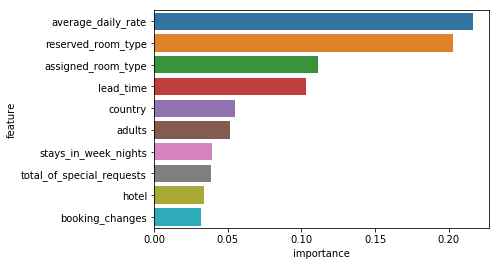

In [26]:
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))

In [4]:
from siuba import *

In [5]:
(hotels >>
    group_by(_.children) >>
    summarize(n = _.children.count(), mean_rate = _.average_daily_rate.mean())
)

,children,n,mean_rate
0,children,4026,148.329101
1,none,45685,95.921748


In [6]:
(hotels >>
    group_by(_.children, _.reserved_room_type) >>
    summarize(n=_.children.count()) >>
    group_by(_.children) >>
    mutate(prop = _.n / _.n.sum()) >>
    ungroup() >>
    select(-_.n) >> 
    spread('children', 'prop') >>
    mutate(diff = (_.children - _.none)) >>
    arrange(-_.diff)
)

,reserved_room_type,children,none,diff
5,F,0.154247,0.014731,0.139516
6,G,0.138351,0.007267,0.131084
2,C,0.072280,0.002736,0.069544
7,H,0.042971,0.001357,0.041614
1,B,0.033532,0.007727,0.025805
4,E,0.066071,0.061421,0.004650
3,D,0.114506,0.179315,-0.064809
0,A,0.378043,0.725402,-0.347359
8,L,NaN,0.000044,NaN


In [7]:
[{name: scorer(best_model, X_test, y_test)} for name, scorer in roc_auc_scorer.items()]

NameError: name 'roc_auc_scorer' is not defined